In [1]:
!pip install torch numpy matplotlib pandas tqdm scipy


Defaulting to user installation because normal site-packages is not writeable


## 1. Setup and Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical, Beta
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import random
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from tqdm import tqdm
import json
import pickle

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Plotting configuration
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

Using device: cuda


## 2. Data Generation - Synthetic Educational Dataset
We'll create a realistic synthetic dataset simulating student learning patterns.

In [4]:
@dataclass
class Student:
    """Represents a student with learning characteristics"""
    id: str
    skill_level: float  # 0.0 to 1.0
    learning_rate: float  # How fast they learn
    consistency: float  # How consistent their performance is
    preferred_difficulty: float  # Optimal challenge level
    knowledge_state: Dict[str, float] = None  # Topic -> mastery level
    
    def __post_init__(self):
        if self.knowledge_state is None:
            self.knowledge_state = {}

class EducationalDataGenerator:
    """Generates synthetic educational interaction data"""
    
    def __init__(self, n_students=100, n_topics=10, n_questions_per_topic=20):
        self.n_students = n_students
        self.n_topics = n_topics
        self.n_questions_per_topic = n_questions_per_topic
        
        # Topics in curriculum
        self.topics = [f"topic_{i}" for i in range(n_topics)]
        
        # Question bank
        self.questions = self._generate_question_bank()
        
        # Generate students
        self.students = self._generate_students()
        
    def _generate_question_bank(self):
        """Create a bank of questions with varying difficulties"""
        questions = {}
        question_id = 0
        
        for topic in self.topics:
            questions[topic] = []
            for _ in range(self.n_questions_per_topic):
                questions[topic].append({
                    'id': question_id,
                    'topic': topic,
                    'difficulty': np.random.uniform(0.1, 1.0),
                    'prerequisite_topics': random.sample(
                        [t for t in self.topics if t != topic], 
                        k=min(2, len(self.topics)-1)
                    ) if random.random() > 0.5 else []
                })
                question_id += 1
                
        return questions
    
    def _generate_students(self):
        """Generate diverse student profiles"""
        students = {}
        
        for i in range(self.n_students):
            student_id = f"student_{i}"
            
            # Sample from different student archetypes
            archetype = np.random.choice(['fast_learner', 'steady_learner', 
                                         'struggling_learner', 'inconsistent_learner'])
            
            if archetype == 'fast_learner':
                skill = np.random.uniform(0.7, 1.0)
                learning_rate = np.random.uniform(0.15, 0.25)
                consistency = np.random.uniform(0.8, 0.95)
            elif archetype == 'steady_learner':
                skill = np.random.uniform(0.4, 0.7)
                learning_rate = np.random.uniform(0.08, 0.15)
                consistency = np.random.uniform(0.7, 0.85)
            elif archetype == 'struggling_learner':
                skill = np.random.uniform(0.2, 0.4)
                learning_rate = np.random.uniform(0.03, 0.08)
                consistency = np.random.uniform(0.5, 0.7)
            else:  # inconsistent_learner
                skill = np.random.uniform(0.3, 0.8)
                learning_rate = np.random.uniform(0.05, 0.20)
                consistency = np.random.uniform(0.3, 0.6)
            
            students[student_id] = Student(
                id=student_id,
                skill_level=skill,
                learning_rate=learning_rate,
                consistency=consistency,
                preferred_difficulty=skill + np.random.uniform(-0.1, 0.2),
                knowledge_state={topic: skill * np.random.uniform(0.5, 1.0) 
                               for topic in self.topics}
            )
            
        return students
    
    def simulate_student_response(self, student_id: str, question: dict) -> Tuple[bool, float]:
        """Simulate whether a student answers correctly"""
        student = self.students[student_id]
        
        # Base probability from skill match
        skill_diff = abs(question['difficulty'] - student.skill_level)
        base_prob = 1.0 / (1.0 + np.exp(5 * (question['difficulty'] - student.skill_level)))
        
        # Adjust for topic knowledge
        topic_knowledge = student.knowledge_state.get(question['topic'], 0.5)
        
        # Adjust for prerequisites
        prereq_bonus = 0
        if question['prerequisite_topics']:
            prereq_knowledge = np.mean([
                student.knowledge_state.get(t, 0.3) 
                for t in question['prerequisite_topics']
            ])
            prereq_bonus = prereq_knowledge * 0.2
        
        # Final probability with consistency factor
        final_prob = base_prob * topic_knowledge + prereq_bonus
        final_prob = np.clip(final_prob, 0.05, 0.95)
        
        # Add noise based on consistency
        noise = np.random.normal(0, (1 - student.consistency) * 0.3)
        final_prob = np.clip(final_prob + noise, 0.05, 0.95)
        
        # Generate response
        correct = np.random.random() < final_prob
        
        # Update student knowledge (learning effect)
        if correct:
            improvement = student.learning_rate * (1 - topic_knowledge) * 0.5
        else:
            improvement = student.learning_rate * 0.1  # Learn from mistakes too
            
        student.knowledge_state[question['topic']] = min(
            1.0, 
            student.knowledge_state[question['topic']] + improvement
        )
        
        return correct, final_prob
    
    def generate_interaction_data(self, n_interactions=10000):
        """Generate a dataset of student-question interactions"""
        data = []
        
        for _ in range(n_interactions):
            # Sample random student and topic
            student_id = random.choice(list(self.students.keys()))
            topic = random.choice(self.topics)
            question = random.choice(self.questions[topic])
            
            # Simulate response
            correct, probability = self.simulate_student_response(student_id, question)
            
            # Store interaction
            data.append({
                'student_id': student_id,
                'question_id': question['id'],
                'topic': topic,
                'difficulty': question['difficulty'],
                'correct': int(correct),
                'probability': probability,
                'skill_level': self.students[student_id].skill_level,
                'topic_knowledge': self.students[student_id].knowledge_state[topic]
            })
            
        return pd.DataFrame(data)

# Generate the dataset
print("Generating synthetic educational dataset...")
data_gen = EducationalDataGenerator(n_students=100, n_topics=10)
train_data = data_gen.generate_interaction_data(n_interactions=10000)
val_data = data_gen.generate_interaction_data(n_interactions=2000)

print(f"\nDataset Statistics:")
print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Overall accuracy: {train_data['correct'].mean():.2%}")
print(f"\nFirst few samples:")
print(train_data.head())


Generating synthetic educational dataset...

Dataset Statistics:
Training samples: 10000
Validation samples: 2000
Overall accuracy: 35.96%

First few samples:
   student_id  question_id    topic  difficulty  correct  probability  \
0  student_74          190  topic_9    0.183792        1     0.494564   
1  student_59          154  topic_7    0.987085        0     0.170596   
2  student_86           76  topic_3    0.794143        0     0.050000   
3  student_60           42  topic_2    0.130950        1     0.521040   
4  student_36          179  topic_8    0.223769        0     0.290596   

   skill_level  topic_knowledge  
0     0.662143         0.653840  
1     0.930156         0.535477  
2     0.395726         0.225115  
3     0.657777         0.495210  
4     0.385290         0.260167  


## 3. Thompson Sampling
Thompson Sampling for exploration and uncertainty-aware decision making.

Testing Thompson Sampler...
Estimated success rates: [0.85714286 0.75       0.33333333 0.25       0.25      ]
Uncertainty levels: [0.12371791 0.12009612 0.23570226 0.19364917 0.19364917]


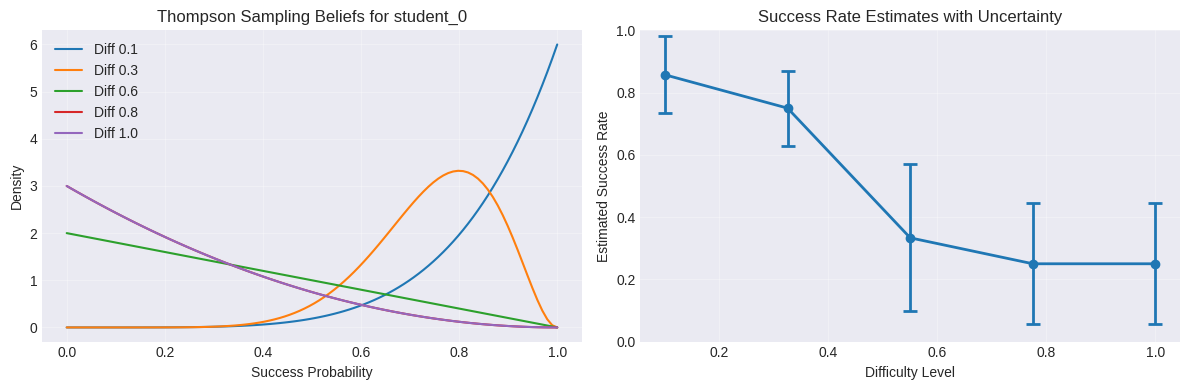

In [5]:
class ThompsonSampler:
    """
    Thompson Sampling for adaptive difficulty selection.
    Maintains Beta distributions for each student-difficulty pair.
    """
    
    def __init__(self, n_difficulty_levels=5, prior_alpha=1.0, prior_beta=1.0):
        self.n_difficulty_levels = n_difficulty_levels
        self.prior_alpha = prior_alpha
        self.prior_beta = prior_beta
        
        # Store Beta parameters for each student and difficulty level
        self.alpha = defaultdict(lambda: np.ones(n_difficulty_levels) * prior_alpha)
        self.beta = defaultdict(lambda: np.ones(n_difficulty_levels) * prior_beta)
        
        # Difficulty bins
        self.difficulty_bins = np.linspace(0.1, 1.0, n_difficulty_levels)
        
        # History tracking
        self.history = defaultdict(list)
        
    def _get_difficulty_bin(self, difficulty: float) -> int:
        """Convert continuous difficulty to discrete bin"""
        return np.argmin(np.abs(self.difficulty_bins - difficulty))
    
    def sample_difficulty(self, student_id: str) -> Tuple[float, np.ndarray]:
        """
        Sample a difficulty level for a student using Thompson Sampling
        Returns: (selected_difficulty, sampling_probabilities)
        """
        # Sample from Beta distributions for each difficulty level
        samples = np.zeros(self.n_difficulty_levels)
        for i in range(self.n_difficulty_levels):
            samples[i] = np.random.beta(
                self.alpha[student_id][i],
                self.beta[student_id][i]
            )
        
        # Select difficulty with highest sampled value
        selected_idx = np.argmax(samples)
        selected_difficulty = self.difficulty_bins[selected_idx]
        
        return selected_difficulty, samples
    
    def update(self, student_id: str, difficulty: float, success: bool):
        """Update Beta distributions based on observed outcome"""
        bin_idx = self._get_difficulty_bin(difficulty)
        
        if success:
            self.alpha[student_id][bin_idx] += 1
        else:
            self.beta[student_id][bin_idx] += 1
            
        # Track history
        self.history[student_id].append({
            'difficulty': difficulty,
            'success': success,
            'alpha': self.alpha[student_id].copy(),
            'beta': self.beta[student_id].copy()
        })
    
    def get_estimated_success_rates(self, student_id: str) -> np.ndarray:
        """Get mean success rate estimates for each difficulty level"""
        mean_rates = self.alpha[student_id] / (self.alpha[student_id] + self.beta[student_id])
        return mean_rates
    
    def get_uncertainty(self, student_id: str) -> np.ndarray:
        """Get uncertainty (std dev) for each difficulty level"""
        a = self.alpha[student_id]
        b = self.beta[student_id]
        variance = (a * b) / ((a + b) ** 2 * (a + b + 1))
        return np.sqrt(variance)
    
    def plot_beliefs(self, student_id: str):
        """Visualize current beliefs about student performance"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot 1: Beta distributions
        x = np.linspace(0, 1, 100)
        for i in range(self.n_difficulty_levels):
            a = self.alpha[student_id][i]
            b = self.beta[student_id][i]
            from scipy.stats import beta
            y = beta.pdf(x, a, b)
            axes[0].plot(x, y, label=f'Diff {self.difficulty_bins[i]:.1f}')
        
        axes[0].set_xlabel('Success Probability')
        axes[0].set_ylabel('Density')
        axes[0].set_title(f'Thompson Sampling Beliefs for {student_id}')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Mean estimates with uncertainty
        means = self.get_estimated_success_rates(student_id)
        stds = self.get_uncertainty(student_id)
        
        axes[1].errorbar(self.difficulty_bins, means, yerr=stds, 
                        marker='o', capsize=5, capthick=2, linewidth=2)
        axes[1].set_xlabel('Difficulty Level')
        axes[1].set_ylabel('Estimated Success Rate')
        axes[1].set_title('Success Rate Estimates with Uncertainty')
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim([0, 1])
        
        plt.tight_layout()
        plt.show()

# Test Thompson Sampler
print("Testing Thompson Sampler...")
thompson = ThompsonSampler(n_difficulty_levels=5)

# Simulate some interactions
test_student = "student_0"
for _ in range(20):
    difficulty, _ = thompson.sample_difficulty(test_student)
    # Simulate success (harder = less likely to succeed)
    success = np.random.random() < (1.0 - difficulty + 0.2)
    thompson.update(test_student, difficulty, success)

print(f"Estimated success rates: {thompson.get_estimated_success_rates(test_student)}")
print(f"Uncertainty levels: {thompson.get_uncertainty(test_student)}")
thompson.plot_beliefs(test_student)

## 4. REINFORCE Policy Network
Neural network policy for selecting optimal teaching actions.

In [6]:
class PolicyNetwork(nn.Module):
    """
    Neural network for REINFORCE algorithm.
    Maps student state to action probabilities.
    """
    
    def __init__(self, state_dim=10, hidden_dim=32, action_dim=5):
        super(PolicyNetwork, self).__init__()
        
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        
        self.dropout = nn.Dropout(0.1)
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        action_logits = self.fc3(x)
        action_probs = F.softmax(action_logits, dim=-1)
        return action_probs

class REINFORCEAgent:
    """
    REINFORCE algorithm for learning optimal teaching policy.
    """
    
    def __init__(self, state_dim=10, action_dim=5, lr=1e-3, gamma=0.99):
        self.device = device
        self.gamma = gamma
        
        # Policy network
        self.policy = PolicyNetwork(state_dim, 32, action_dim).to(device)
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        
        # Action space (different teaching strategies)
        self.actions = ['very_easy', 'easy', 'medium', 'hard', 'very_hard']
        self.action_dim = action_dim
        
        # Episode storage
        self.saved_log_probs = []
        self.rewards = []
        
        # Training history
        self.loss_history = []
        self.reward_history = []
        
    def encode_state(self, student_data: dict) -> torch.Tensor:
        """Convert student data to state vector"""
        state = np.array([
            student_data.get('skill_level', 0.5),
            student_data.get('recent_performance', 0.5),
            student_data.get('topic_knowledge', 0.5),
            student_data.get('attempts_count', 0) / 100,
            student_data.get('correct_rate', 0.5),
            student_data.get('avg_difficulty', 0.5),
            student_data.get('time_since_last', 0) / 60,
            student_data.get('streak', 0) / 10,
            student_data.get('hint_usage', 0) / 5,
            student_data.get('session_length', 0) / 20,
        ])
        return torch.FloatTensor(state).to(self.device)
    
    def select_action(self, state: torch.Tensor, explore=True) -> Tuple[int, torch.Tensor]:
        """Select action using policy network"""
        action_probs = self.policy(state)
        
        if explore:
            dist = Categorical(action_probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        else:
            action = torch.argmax(action_probs)
            log_prob = torch.log(action_probs[action])
        
        return action.item(), log_prob
    
    def store_transition(self, log_prob: torch.Tensor, reward: float):
        """Store transition for episode"""
        self.saved_log_probs.append(log_prob)
        self.rewards.append(reward)
    
    def compute_returns(self, normalize=True):
        """Calculate discounted returns"""
        returns = []
        R = 0
        
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns, dtype=torch.float32).to(self.device)
        
        if normalize and len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        
        return returns
    
    def update_policy(self):
        """REINFORCE update step"""
        if len(self.rewards) == 0:
            return
        
        returns = self.compute_returns()
        policy_loss = []
        
        for log_prob, R in zip(self.saved_log_probs, returns):
            policy_loss.append(-log_prob * R)
        
        # Compute total loss
        loss = torch.stack(policy_loss).sum()
        
        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        # Store history
        self.loss_history.append(loss.item())
        self.reward_history.append(sum(self.rewards))
        
        # Clear episode data
        self.saved_log_probs = []
        self.rewards = []
        
        return loss.item()
    
    def save_model(self, path='reinforce_model.pth'):
        """Save model checkpoint"""
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss_history': self.loss_history,
            'reward_history': self.reward_history,
        }, path)
    
    def load_model(self, path='reinforce_model.pth'):
        """Load model checkpoint"""
        checkpoint = torch.load(path, map_location=self.device)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.loss_history = checkpoint['loss_history']
        self.reward_history = checkpoint['reward_history']

# Test REINFORCE Agent
print("Testing REINFORCE Agent...")
reinforce = REINFORCEAgent(state_dim=10, action_dim=5)

# Simulate a short episode
test_state = {'skill_level': 0.6, 'recent_performance': 0.7, 'topic_knowledge': 0.5}
state_tensor = reinforce.encode_state(test_state)

for step in range(5):
    action, log_prob = reinforce.select_action(state_tensor)
    reward = np.random.random()  # Simulated reward
    reinforce.store_transition(log_prob, reward)
    print(f"Step {step}: Action={reinforce.actions[action]}, Reward={reward:.2f}")

loss = reinforce.update_policy()
print(f"Policy updated. Loss: {loss:.4f}")

Testing REINFORCE Agent...
Step 0: Action=very_easy, Reward=0.06
Step 1: Action=medium, Reward=0.47
Step 2: Action=easy, Reward=0.21
Step 3: Action=easy, Reward=0.09
Step 4: Action=very_easy, Reward=0.41
Policy updated. Loss: -0.1682


## 5. Combined Training System
Integrate Thompson Sampling and REINFORCE for adaptive education.

Initializing Adaptive Learning System...

Starting training...


Training: 100%|██████████| 10000/10000 [03:54<00:00, 42.61it/s, Avg Reward=15.62, Accuracy=78.00%, Policy Loss=-11.2030]



Training completed!
Final average reward: 15.62
Final accuracy: 78.00%

Plotting results...


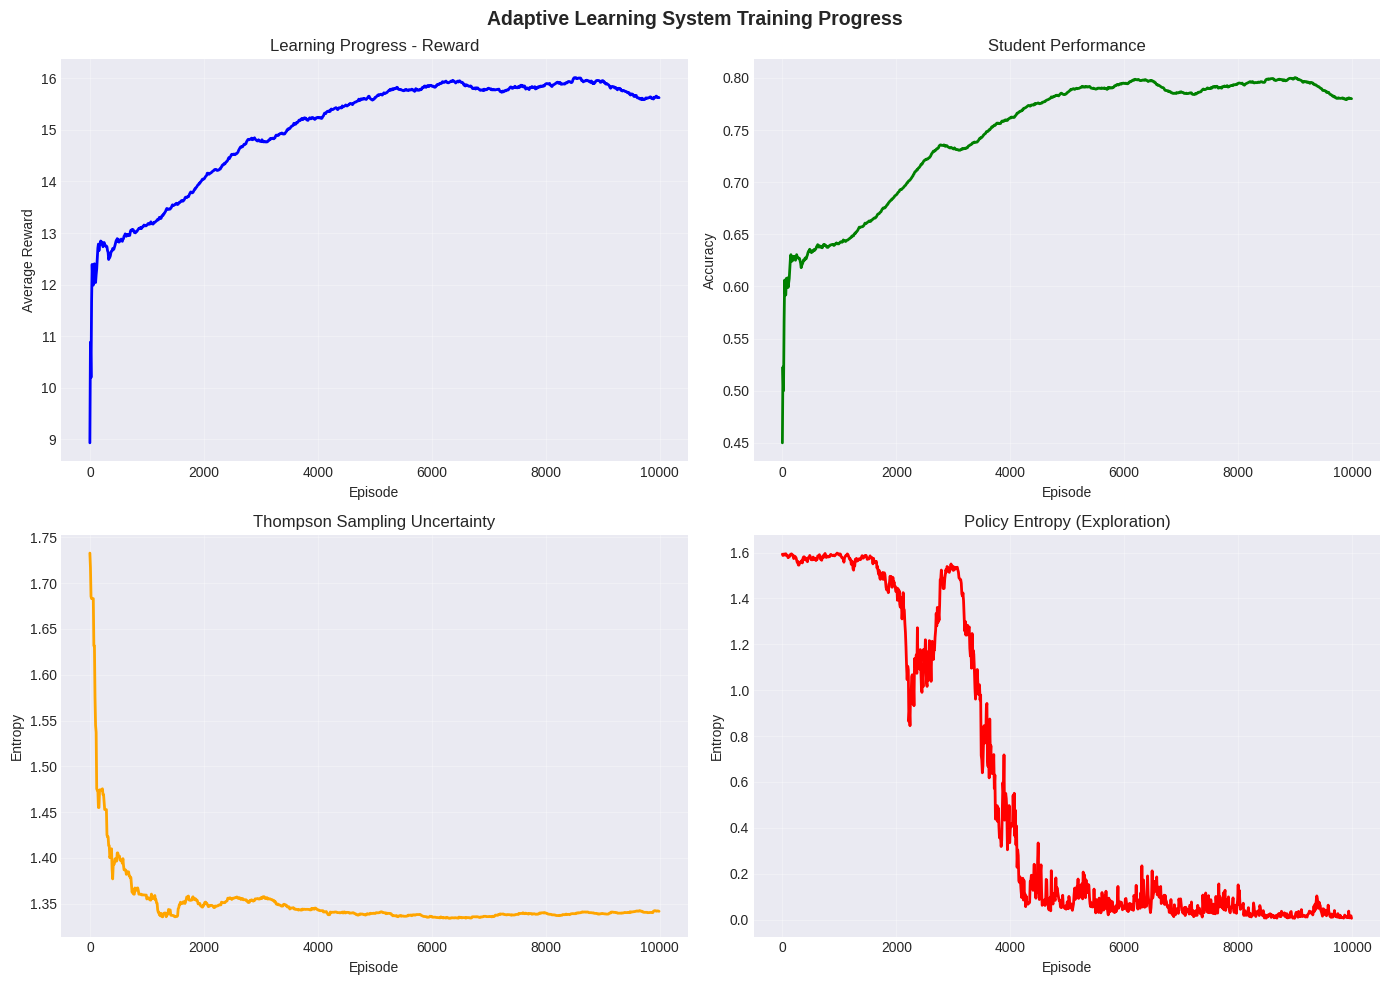

In [9]:
class AdaptiveLearningSystem:
    """
    Complete adaptive learning system combining Thompson Sampling and REINFORCE.
    """
    
    def __init__(self, data_generator, n_difficulty_levels=5):
        self.data_gen = data_generator
        
        # Initialize RL components
        self.thompson = ThompsonSampler(n_difficulty_levels=n_difficulty_levels)
        self.reinforce = REINFORCEAgent(state_dim=10, action_dim=n_difficulty_levels)
        
        # Performance tracking
        self.episode_rewards = []
        self.student_progress = defaultdict(list)
        self.training_metrics = {
            'episode': [],
            'avg_reward': [],
            'accuracy': [],
            'thompson_entropy': [],
            'policy_entropy': []
        }
        
    def get_student_state(self, student_id: str, history: list) -> dict:
        """Compute current state features for a student"""
        if not history:
            return {
                'skill_level': 0.5,
                'recent_performance': 0.5,
                'topic_knowledge': 0.5,
                'attempts_count': 0,
                'correct_rate': 0.5,
                'avg_difficulty': 0.5,
                'time_since_last': 0,
                'streak': 0,
                'hint_usage': 0,
                'session_length': 0
            }
        
        recent = history[-10:] if len(history) >= 10 else history
        
        return {
            'skill_level': self.data_gen.students[student_id].skill_level,
            'recent_performance': np.mean([h['correct'] for h in recent]),
            'topic_knowledge': np.mean([
                self.data_gen.students[student_id].knowledge_state.get(h['topic'], 0.5) 
                for h in recent
            ]),
            'attempts_count': len(history),
            'correct_rate': np.mean([h['correct'] for h in history]),
            'avg_difficulty': np.mean([h['difficulty'] for h in recent]),
            'time_since_last': 0,  # Simplified
            'streak': self._calculate_streak(history),
            'hint_usage': 0,  # Simplified
            'session_length': len(history)
        }
    
    def _calculate_streak(self, history: list) -> int:
        """Calculate current correct answer streak"""
        if not history:
            return 0
        streak = 0
        for h in reversed(history):
            if h['correct']:
                streak += 1
            else:
                break
        return streak
    
    def compute_reward(self, correct: bool, difficulty: float, 
                      student_skill: float, optimal_difficulty: float) -> float:
        """
        Compute reward based on:
        - Correctness
        - Difficulty appropriateness
        - Learning progress
        """
        # Base reward for correct/incorrect
        base_reward = 1.0 if correct else -0.3
        
        # Bonus for appropriate difficulty (zone of proximal development)
        diff_distance = abs(difficulty - optimal_difficulty)
        difficulty_bonus = np.exp(-5 * diff_distance)
        
        # Learning efficiency bonus
        if correct and difficulty > student_skill:
            learning_bonus = 0.5  # Succeeded on harder problem
        elif not correct and difficulty < student_skill:
            learning_bonus = -0.3  # Failed on easier problem
        else:
            learning_bonus = 0
        
        total_reward = base_reward + 0.3 * difficulty_bonus + learning_bonus
        
        return np.clip(total_reward, -1, 2)
    
    def run_episode(self, student_id: str, episode_length: int = 20) -> dict:
        """Run one learning episode for a student"""
        history = []
        episode_rewards = []
        student = self.data_gen.students[student_id]
        
        for step in range(episode_length):
            # Get current state
            state_dict = self.get_student_state(student_id, history)
            state_tensor = self.reinforce.encode_state(state_dict)
            
            # Thompson sampling for exploration
            thompson_difficulty, thompson_probs = self.thompson.sample_difficulty(student_id)
            
            # REINFORCE for action selection
            action, log_prob = self.reinforce.select_action(state_tensor)
            
            # Combine both methods (weighted average)
            thompson_weight = 0.3  # Can be adaptive
            final_difficulty = (thompson_weight * thompson_difficulty + 
                              (1 - thompson_weight) * self.thompson.difficulty_bins[action])
            
            # Select question based on difficulty
            topic = random.choice(self.data_gen.topics)
            available_questions = self.data_gen.questions[topic]
            question = min(available_questions, 
                          key=lambda q: abs(q['difficulty'] - final_difficulty))
            
            # Simulate student response
            correct, prob = self.data_gen.simulate_student_response(student_id, question)
            
            # Compute reward
            optimal_diff = student.skill_level + 0.1  # Slightly above current level
            reward = self.compute_reward(correct, question['difficulty'], 
                                        student.skill_level, optimal_diff)
            
            # Store transition
            self.reinforce.store_transition(log_prob, reward)
            episode_rewards.append(reward)
            
            # Update Thompson sampler
            self.thompson.update(student_id, question['difficulty'], correct)
            
            # Record history
            history.append({
                'step': step,
                'topic': topic,
                'difficulty': question['difficulty'],
                'correct': correct,
                'probability': prob,
                'reward': reward
            })
        
        # Update REINFORCE policy
        policy_loss = self.reinforce.update_policy()
        
        # Store episode metrics
        episode_metrics = {
            'student_id': student_id,
            'total_reward': sum(episode_rewards),
            'accuracy': np.mean([h['correct'] for h in history]),
            'avg_difficulty': np.mean([h['difficulty'] for h in history]),
            'policy_loss': policy_loss if policy_loss else 0,
            'final_knowledge': np.mean(list(student.knowledge_state.values()))
        }
        
        self.student_progress[student_id].append(episode_metrics)
        
        return episode_metrics
    
    def train(self, n_episodes: int = 10000, verbose: bool = True):
        """Train the adaptive learning system"""
        
        progress_bar = tqdm(range(n_episodes), desc="Training")
        
        for episode in progress_bar:
            # Sample random student
            student_id = random.choice(list(self.data_gen.students.keys()))
            
            # Run episode
            metrics = self.run_episode(student_id)
            
            # Track metrics
            if episode % 10 == 0:
                recent_rewards = [
                    ep['total_reward'] 
                    for progress in self.student_progress.values() 
                    for ep in progress[-10:]
                ]
                avg_reward = np.mean(recent_rewards) if recent_rewards else 0
                
                recent_accuracy = [
                    ep['accuracy'] 
                    for progress in self.student_progress.values() 
                    for ep in progress[-10:]
                ]
                avg_accuracy = np.mean(recent_accuracy) if recent_accuracy else 0
                
                self.training_metrics['episode'].append(episode)
                self.training_metrics['avg_reward'].append(avg_reward)
                self.training_metrics['accuracy'].append(avg_accuracy)
                
                # Calculate Thompson entropy (uncertainty)
                thompson_entropy = np.mean([
                    -np.sum(p * np.log(p + 1e-8)) 
                    for p in [self.thompson.get_estimated_success_rates(sid) 
                             for sid in list(self.data_gen.students.keys())[:10]]
                ])
                self.training_metrics['thompson_entropy'].append(thompson_entropy)
                
                # Calculate policy entropy
                sample_states = torch.stack([
                    self.reinforce.encode_state(self.get_student_state(sid, []))
                    for sid in list(self.data_gen.students.keys())[:10]
                ])
                with torch.no_grad():
                    action_probs = self.reinforce.policy(sample_states)
                    policy_entropy = -torch.sum(action_probs * torch.log(action_probs + 1e-8), 
                                               dim=1).mean().item()
                self.training_metrics['policy_entropy'].append(policy_entropy)
                
                progress_bar.set_postfix({
                    'Avg Reward': f'{avg_reward:.2f}',
                    'Accuracy': f'{avg_accuracy:.2%}',
                    'Policy Loss': f'{metrics["policy_loss"]:.4f}'
                })
        
        if verbose:
            print(f"\nTraining completed!")
            print(f"Final average reward: {self.training_metrics['avg_reward'][-1]:.2f}")
            print(f"Final accuracy: {self.training_metrics['accuracy'][-1]:.2%}")
    
    def plot_training_progress(self):
        """Visualize training progress"""
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Plot 1: Average Reward
        axes[0, 0].plot(self.training_metrics['episode'], 
                       self.training_metrics['avg_reward'], 
                       linewidth=2, color='blue')
        axes[0, 0].set_xlabel('Episode')
        axes[0, 0].set_ylabel('Average Reward')
        axes[0, 0].set_title('Learning Progress - Reward')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Accuracy
        axes[0, 1].plot(self.training_metrics['episode'], 
                       self.training_metrics['accuracy'], 
                       linewidth=2, color='green')
        axes[0, 1].set_xlabel('Episode')
        axes[0, 1].set_ylabel('Accuracy')
        axes[0, 1].set_title('Student Performance')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Thompson Entropy
        axes[1, 0].plot(self.training_metrics['episode'], 
                       self.training_metrics['thompson_entropy'], 
                       linewidth=2, color='orange')
        axes[1, 0].set_xlabel('Episode')
        axes[1, 0].set_ylabel('Entropy')
        axes[1, 0].set_title('Thompson Sampling Uncertainty')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Policy Entropy
        axes[1, 1].plot(self.training_metrics['episode'], 
                       self.training_metrics['policy_entropy'], 
                       linewidth=2, color='red')
        axes[1, 1].set_xlabel('Episode')
        axes[1, 1].set_ylabel('Entropy')
        axes[1, 1].set_title('Policy Entropy (Exploration)')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle('Adaptive Learning System Training Progress', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

# Create and train the system
print("Initializing Adaptive Learning System...")
adaptive_system = AdaptiveLearningSystem(data_gen)

print("\nStarting training...")
adaptive_system.train(n_episodes=10000)

print("\nPlotting results...")
adaptive_system.plot_training_progress()

## 6. Evaluation and Analysis
Evaluate the trained system and analyze its performance.

Evaluating the trained system...

1. Testing adaptation to different student types...

2. Comparing with baseline strategies...

3. Generating visualizations...


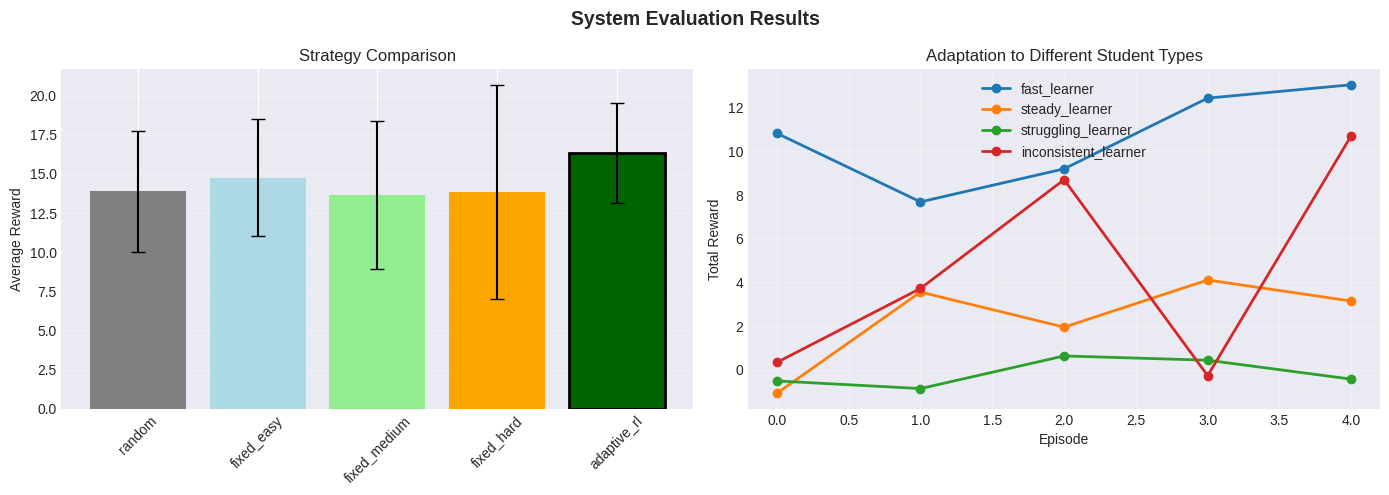


4. Final Report:
ADAPTIVE LEARNING SYSTEM EVALUATION REPORT

BASELINE COMPARISON:
----------------------------------------

RANDOM:
  Average Reward: 13.89 ± 3.88
  Average Accuracy: 65.50% ± 15.76%

FIXED_EASY:
  Average Reward: 14.75 ± 3.73
  Average Accuracy: 75.80% ± 17.70%

FIXED_MEDIUM:
  Average Reward: 13.65 ± 4.75
  Average Accuracy: 62.60% ± 23.96%

FIXED_HARD:
  Average Reward: 13.84 ± 6.81
  Average Accuracy: 57.00% ± 25.06%

ADAPTIVE_RL:
  Average Reward: 16.33 ± 3.22
  Average Accuracy: 83.10% ± 11.31%

Best Strategy: ADAPTIVE_RL
Improvement over random: 17.6%


STUDENT TYPE ADAPTATION:
----------------------------------------

Fast Learner:
  Average Reward: 10.64
  Average Accuracy: 69.00%

Steady Learner:
  Average Reward: 2.33
  Average Accuracy: 32.00%

Struggling Learner:
  Average Reward: -0.15
  Average Accuracy: 10.00%

Inconsistent Learner:
  Average Reward: 4.64
  Average Accuracy: 34.00%



In [10]:
class SystemEvaluator:
    """Evaluate and analyze the trained adaptive learning system"""
    
    def __init__(self, adaptive_system: AdaptiveLearningSystem):
        self.system = adaptive_system
        self.evaluation_results = {}
        
    def evaluate_student_adaptation(self, n_students: int = 10, n_episodes: int = 5):
        """Test how well the system adapts to different student types"""
        results = {
            'fast_learner': [],
            'steady_learner': [],
            'struggling_learner': [],
            'inconsistent_learner': []
        }
        
        # Create test students of each type
        test_students = {
            'fast_learner': Student('test_fast', 0.85, 0.20, 0.90, 0.85),
            'steady_learner': Student('test_steady', 0.55, 0.12, 0.75, 0.55),
            'struggling_learner': Student('test_struggling', 0.30, 0.05, 0.60, 0.35),
            'inconsistent_learner': Student('test_inconsistent', 0.50, 0.10, 0.40, 0.55)
        }
        
        for student_type, student in test_students.items():
            # Initialize knowledge state
            student.knowledge_state = {
                topic: student.skill_level * np.random.uniform(0.5, 1.0) 
                for topic in self.system.data_gen.topics
            }
            
            # Add to data generator
            self.system.data_gen.students[student.id] = student
            
            # Run episodes
            for _ in range(n_episodes):
                metrics = self.system.run_episode(student.id, episode_length=20)
                results[student_type].append(metrics)
        
        self.evaluation_results['adaptation'] = results
        return results
    
    def compare_with_baselines(self, n_episodes: int = 100):
        """Compare with baseline strategies"""
        baselines = {
            'random': self._random_baseline,
            'fixed_easy': lambda s: 0.3,
            'fixed_medium': lambda s: 0.5,
            'fixed_hard': lambda s: 0.7,
            'adaptive_rl': self._adaptive_rl_strategy
        }
        
        results = {}
        
        for name, strategy in baselines.items():
            total_rewards = []
            accuracies = []
            
            for _ in range(n_episodes):
                student_id = random.choice(list(self.system.data_gen.students.keys()))
                student = self.system.data_gen.students[student_id]
                
                episode_reward = 0
                correct_count = 0
                
                for step in range(20):
                    # Get difficulty from strategy
                    if name == 'adaptive_rl':
                        difficulty = strategy(student_id)
                    else:
                        difficulty = strategy(student)
                    
                    # Select question
                    topic = random.choice(self.system.data_gen.topics)
                    questions = self.system.data_gen.questions[topic]
                    question = min(questions, key=lambda q: abs(q['difficulty'] - difficulty))
                    
                    # Simulate response
                    correct, _ = self.system.data_gen.simulate_student_response(student_id, question)
                    
                    # Calculate reward
                    optimal_diff = student.skill_level + 0.1
                    reward = self.system.compute_reward(
                        correct, question['difficulty'], 
                        student.skill_level, optimal_diff
                    )
                    
                    episode_reward += reward
                    correct_count += int(correct)
                
                total_rewards.append(episode_reward)
                accuracies.append(correct_count / 20)
            
            results[name] = {
                'avg_reward': np.mean(total_rewards),
                'std_reward': np.std(total_rewards),
                'avg_accuracy': np.mean(accuracies),
                'std_accuracy': np.std(accuracies)
            }
        
        self.evaluation_results['baselines'] = results
        return results
    
    def _random_baseline(self, student):
        """Random difficulty selection"""
        return np.random.uniform(0.1, 1.0)
    
    def _adaptive_rl_strategy(self, student_id):
        """Use the trained RL system"""
        state_dict = self.system.get_student_state(student_id, [])
        state_tensor = self.system.reinforce.encode_state(state_dict)
        
        with torch.no_grad():
            action_probs = self.system.reinforce.policy(state_tensor)
            action = torch.argmax(action_probs).item()
        
        thompson_diff, _ = self.system.thompson.sample_difficulty(student_id)
        
        # Weighted combination
        rl_diff = self.system.thompson.difficulty_bins[action]
        final_diff = 0.3 * thompson_diff + 0.7 * rl_diff
        
        return final_diff
    
    def plot_evaluation_results(self):
        """Visualize evaluation results"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Baseline comparison
        if 'baselines' in self.evaluation_results:
            baselines = self.evaluation_results['baselines']
            
            names = list(baselines.keys())
            avg_rewards = [baselines[n]['avg_reward'] for n in names]
            std_rewards = [baselines[n]['std_reward'] for n in names]
            
            x_pos = np.arange(len(names))
            bars = axes[0].bar(x_pos, avg_rewards, yerr=std_rewards, 
                              capsize=5, color=['gray', 'lightblue', 'lightgreen', 
                                               'orange', 'darkgreen'])
            axes[0].set_xticks(x_pos)
            axes[0].set_xticklabels(names, rotation=45)
            axes[0].set_ylabel('Average Reward')
            axes[0].set_title('Strategy Comparison')
            axes[0].grid(True, alpha=0.3, axis='y')
            
            # Highlight best
            best_idx = np.argmax(avg_rewards)
            bars[best_idx].set_color('darkgreen')
            bars[best_idx].set_edgecolor('black')
            bars[best_idx].set_linewidth(2)
        
        # Plot 2: Student adaptation
        if 'adaptation' in self.evaluation_results:
            adaptation = self.evaluation_results['adaptation']
            
            for student_type, episodes in adaptation.items():
                if episodes:
                    rewards = [ep['total_reward'] for ep in episodes]
                    axes[1].plot(rewards, marker='o', label=student_type, linewidth=2)
            
            axes[1].set_xlabel('Episode')
            axes[1].set_ylabel('Total Reward')
            axes[1].set_title('Adaptation to Different Student Types')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        plt.suptitle('System Evaluation Results', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    def generate_report(self):
        """Generate a text report of evaluation results"""
        report = []
        report.append("=" * 60)
        report.append("ADAPTIVE LEARNING SYSTEM EVALUATION REPORT")
        report.append("=" * 60)
        
        if 'baselines' in self.evaluation_results:
            report.append("\nBASELINE COMPARISON:")
            report.append("-" * 40)
            
            baselines = self.evaluation_results['baselines']
            for name, metrics in baselines.items():
                report.append(f"\n{name.upper()}:")
                report.append(f"  Average Reward: {metrics['avg_reward']:.2f} ± {metrics['std_reward']:.2f}")
                report.append(f"  Average Accuracy: {metrics['avg_accuracy']:.2%} ± {metrics['std_accuracy']:.2%}")
            
            # Find best strategy
            best_strategy = max(baselines.items(), key=lambda x: x[1]['avg_reward'])
            report.append(f"\nBest Strategy: {best_strategy[0].upper()}")
            
            # Calculate improvement
            if 'random' in baselines and 'adaptive_rl' in baselines:
                random_reward = baselines['random']['avg_reward']
                rl_reward = baselines['adaptive_rl']['avg_reward']
                improvement = ((rl_reward - random_reward) / abs(random_reward)) * 100
                report.append(f"Improvement over random: {improvement:.1f}%")
        
        if 'adaptation' in self.evaluation_results:
            report.append("\n\nSTUDENT TYPE ADAPTATION:")
            report.append("-" * 40)
            
            adaptation = self.evaluation_results['adaptation']
            for student_type, episodes in adaptation.items():
                if episodes:
                    avg_reward = np.mean([ep['total_reward'] for ep in episodes])
                    avg_accuracy = np.mean([ep['accuracy'] for ep in episodes])
                    report.append(f"\n{student_type.replace('_', ' ').title()}:")
                    report.append(f"  Average Reward: {avg_reward:.2f}")
                    report.append(f"  Average Accuracy: {avg_accuracy:.2%}")
        
        report.append("\n" + "=" * 60)
        
        return "\n".join(report)

# Evaluate the trained system
print("Evaluating the trained system...")
evaluator = SystemEvaluator(adaptive_system)

print("\n1. Testing adaptation to different student types...")
adaptation_results = evaluator.evaluate_student_adaptation(n_episodes=5)

print("\n2. Comparing with baseline strategies...")
baseline_results = evaluator.compare_with_baselines(n_episodes=50)

print("\n3. Generating visualizations...")
evaluator.plot_evaluation_results()

print("\n4. Final Report:")
print(evaluator.generate_report())

## 7. Save and Export Trained Models
Save the trained models for future use in agent integration.

In [11]:
# Save the trained models
print("Saving trained models...")

# Save REINFORCE model
adaptive_system.reinforce.save_model('reinforce_model.pth')
print("REINFORCE model saved to 'reinforce_model.pth'")

# Save Thompson Sampler state
import pickle
with open('thompson_sampler.pkl', 'wb') as f:
    pickle.dump({
        'alpha': dict(adaptive_system.thompson.alpha),
        'beta': dict(adaptive_system.thompson.beta),
        'difficulty_bins': adaptive_system.thompson.difficulty_bins,
        'history': dict(adaptive_system.thompson.history)
    }, f)
print("Thompson Sampler saved to 'thompson_sampler.pkl'")

# Save training metrics
with open('training_metrics.json', 'w') as f:
    json.dump(adaptive_system.training_metrics, f, indent=2)
print("Training metrics saved to 'training_metrics.json'")

# Save evaluation results
with open('evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluator.evaluation_results, f)
print("Evaluation results saved to 'evaluation_results.pkl'")

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print("\nSummary:")
print(f"  • Episodes trained: {len(adaptive_system.training_metrics['episode']) * 10}")
print(f"  • Final accuracy: {adaptive_system.training_metrics['accuracy'][-1]:.2%}")
print(f"  • Final avg reward: {adaptive_system.training_metrics['avg_reward'][-1]:.2f}")

if 'baselines' in evaluator.evaluation_results:
    baselines = evaluator.evaluation_results['baselines']
    if 'random' in baselines and 'adaptive_rl' in baselines:
        improvement = ((baselines['adaptive_rl']['avg_reward'] - 
                       baselines['random']['avg_reward']) / 
                      abs(baselines['random']['avg_reward'])) * 100
        print(f"  • Improvement over random: {improvement:.1f}%")

print("\nNext steps:")
print("  1. Use saved models for agent integration")
print("  2. Deploy as Adaptive Tutorial Agent")
print("  3. Build UI for real-time interaction")
print("\n✨ Ready for production deployment!")

Saving trained models...
REINFORCE model saved to 'reinforce_model.pth'
Thompson Sampler saved to 'thompson_sampler.pkl'
Training metrics saved to 'training_metrics.json'
Evaluation results saved to 'evaluation_results.pkl'

TRAINING COMPLETE!

Summary:
  • Episodes trained: 10000
  • Final accuracy: 78.00%
  • Final avg reward: 15.62
  • Improvement over random: 17.6%

Next steps:
  1. Use saved models for agent integration
  2. Deploy as Adaptive Tutorial Agent
  3. Build UI for real-time interaction

✨ Ready for production deployment!


## 8. Quick Test - Interactive Demo
Test the trained system with a simulated student session.

In [13]:
def interactive_demo(adaptive_system, student_id='demo_student', n_questions=10):
    """Run an interactive demo session"""
    print("="*60)
    print("ADAPTIVE LEARNING DEMO SESSION")
    print("="*60)
    
    # Create a demo student
    demo_student = Student(
        id=student_id,
        skill_level=0.5,
        learning_rate=0.15,
        consistency=0.7,
        preferred_difficulty=0.55
    )
    demo_student.knowledge_state = {
        topic: 0.5 for topic in adaptive_system.data_gen.topics
    }
    adaptive_system.data_gen.students[student_id] = demo_student
    
    history = []
    
    for q_num in range(n_questions):
        print(f"\nQuestion {q_num + 1}/{n_questions}")
        print("-" * 40)
        
        # Get state and select action
        state_dict = adaptive_system.get_student_state(student_id, history)
        state_tensor = adaptive_system.reinforce.encode_state(state_dict)
        
        # Get recommendations from both methods
        thompson_diff, _ = adaptive_system.thompson.sample_difficulty(student_id)
        
        with torch.no_grad():
            action_probs = adaptive_system.reinforce.policy(state_tensor)
            rl_action = torch.argmax(action_probs).item()
            rl_diff = adaptive_system.thompson.difficulty_bins[rl_action]
        
        # Combine recommendations
        final_diff = 0.3 * thompson_diff + 0.7 * rl_diff
        
        # Select question
        topic = random.choice(adaptive_system.data_gen.topics)
        questions = adaptive_system.data_gen.questions[topic]
        question = min(questions, key=lambda q: abs(q['difficulty'] - final_diff))
        
        print(f"Topic: {topic}")
        print(f"Difficulty: {question['difficulty']:.2f}")
        print(f"   (Thompson: {thompson_diff:.2f}, RL: {rl_diff:.2f})")
        
        # Simulate response
        correct, prob = adaptive_system.data_gen.simulate_student_response(student_id, question)
        
        print(f"Result: {'CORRECT' if correct else '❌ INCORRECT'}")
        print(f"📉 Success probability was: {prob:.2%}")
        
        # Update models
        adaptive_system.thompson.update(student_id, question['difficulty'], correct)
        
        # Update history
        history.append({
            'topic': topic,
            'difficulty': question['difficulty'],
            'correct': correct
        })
    
    # Final summary
    print("\n" + "="*60)
    print("SESSION SUMMARY")
    print("="*60)
    accuracy = np.mean([h['correct'] for h in history])
    avg_difficulty = np.mean([h['difficulty'] for h in history])
    
    print(f"Accuracy: {accuracy:.1%}")
    print(f"Average Difficulty: {avg_difficulty:.2f}")
    print(f"Student Skill Level: {demo_student.skill_level:.2f}")
    
    # Show adaptation
    thompson_beliefs = adaptive_system.thompson.get_estimated_success_rates(student_id)
    print(f"\nLearned Success Rates by Difficulty:")
    for i, diff in enumerate(adaptive_system.thompson.difficulty_bins):
        print(f"   Difficulty {diff:.1f}: {thompson_beliefs[i]:.1%}")

# Run the demo
print("Running interactive demo...")
interactive_demo(adaptive_system)

Running interactive demo...
ADAPTIVE LEARNING DEMO SESSION

Question 1/10
----------------------------------------
Topic: topic_2
Difficulty: 0.33
   (Thompson: 0.33, RL: 0.33)
Result: CORRECT
📉 Success probability was: 36.03%

Question 2/10
----------------------------------------
Topic: topic_0
Difficulty: 0.29
   (Thompson: 0.33, RL: 0.33)
Result: ❌ INCORRECT
📉 Success probability was: 29.10%

Question 3/10
----------------------------------------
Topic: topic_5
Difficulty: 0.27
   (Thompson: 0.10, RL: 0.33)
Result: ❌ INCORRECT
📉 Success probability was: 46.59%

Question 4/10
----------------------------------------
Topic: topic_1
Difficulty: 0.25
   (Thompson: 0.10, RL: 0.33)
Result: ❌ INCORRECT
📉 Success probability was: 51.43%

Question 5/10
----------------------------------------
Topic: topic_9
Difficulty: 0.58
   (Thompson: 1.00, RL: 0.33)
Result: ❌ INCORRECT
📉 Success probability was: 9.95%

Question 6/10
----------------------------------------
Topic: topic_9
Difficulty: 0.2